In [1]:
import numpy as np
import pandas as pd
import random
import torch
import math
from Bio import SeqIO
import Bio.PDB
import pickle as pickle
import matplotlib.pyplot as plt
import os
from Bio import PDB

**Insert the path to the PDB Refines set from PDBind** 

In [2]:
class CFG:
    pdbfiles: str = "/home/paul/Desktop/BioHack-Project-Walkthrough/pdbind-refined-set/"

In [3]:
def remove_hetatm(input_pdb_file, output_pdb_file):
    "Removes HETATMS from raw PDB Files and outputs the clean PDB into a new file location"
    # Open the input PDB file for reading and the output PDB file for writing
    with open(input_pdb_file, 'r') as infile, open(output_pdb_file, 'w') as outfile:
        for line in infile:
            # Check if the line starts with 'HETATM' (non-protein atoms)
            if line.startswith('HETATM'):
                continue  # Skip this line (HETATM record)
            # Write all other lines to the output file
            outfile.write(line)
def remove_missing_alpha_carbons(input_pdb_file, output_pdb_file):
    "Removes all residues from a PDB file if the alpha carbon is missing"
    # Parse the input PDB file
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('structure', input_pdb_file)

    # Iterate over residues and identify those missing alpha carbons
    residues_to_remove = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' not in residue:
                    residues_to_remove.append(residue)

    # Remove identified residues from the structure
    for residue in residues_to_remove:
        chain = residue.get_parent()
        chain.detach_child(residue.id)

    # Save the modified structure to the output file
    io = PDB.PDBIO()
    io.set_structure(structure)
    io.save(output_pdb_file)
    
def get_atom_types_from_mol2_split(mol2_file):
    "Returns a set of the atoms present in a Mol2 File"
    atom_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atom_types.add(atom_type)
    
    atom_types_split = set()
    for atom in atom_types:
        atom_types_split.add(str(atom).split('.')[0])
        

    return sorted(list(atom_types_split))

def get_bond_types_from_mol2(mol2_file):
    "Returns a set of bond types present in a Mol2 File"
    bond_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                break

            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    bond_type = parts[3]
                    bond_types.add(bond_type)

    return sorted(list(bond_types))

def dict2embeding(dict_):
    "Convert dictionary to a new dictionary containing the OHEings"
    count = 0
    out_id = {}
    for i in dict_:
        x = np.zeros(len(dict_))
        x[count] = 1.
        count +=1
        out_id.update({str(i): x})
    return out_id

AA_dictionary = {'GLY':torch.Tensor([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'ALA':torch.Tensor([0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'VAL':torch.Tensor([0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'CYS':torch.Tensor([0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'PRO':torch.Tensor([0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'LEU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'ILE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'MET':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'TRP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'PHE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'LYS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'ARG':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'HIS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'SER':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'THR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]),
            'TYR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]),
            'ASN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]),
            'GLN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]),
            'ASP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]),
            'GLU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]),}

Ensure all PDB Files are present (There should be 5316)

In [5]:
total_count = 0
file_count = 0
for filename in os.listdir(CFG.pdbfiles):
    num_files = 0
    for file in os.listdir(CFG.pdbfiles+filename):
        num_files += 1
    if num_files > 0:
        file_count += 1
    total_count += 1

print(total_count)
print(file_count)

5316
5316


Remove all HETATMS from the PDB Files -<br>
All Ligands are stored in seperate files as either SDF or Mol2 Files so this command only removes water, ions and crystalographic additives.<br> These HETATMS also need to be removed from the binding pocket PDB files. Some of the binding pockets contain residues with missing backbone atoms. These residues need to be deleted

In [6]:
for filename in os.listdir(CFG.pdbfiles):
    input_pdb_filename = CFG.pdbfiles+filename+'/'+filename+'_protein'
    output_pdb_filename = input_pdb_filename+'_clean.pdb'
    remove_hetatm(input_pdb_filename+'.pdb', output_pdb_filename)

for filename in os.listdir(CFG.pdbfiles):
    input_pdb_filename = CFG.pdbfiles+filename+'/'+filename+'_pocket'
    output_pdb_filename = input_pdb_filename+'_clean.pdb'
    remove_hetatm(input_pdb_filename+'.pdb', output_pdb_filename)

for filename in os.listdir(CFG.pdbfiles):
    input_pdb_filename = CFG.pdbfiles+filename+'/'+filename+'_pocket'
    output_pdb_filename = input_pdb_filename+'_clean.pdb'
    remove_missing_alpha_carbons(output_pdb_filename, output_pdb_filename)

Exploring the dataset -<br>Find all elemnts present is the set of ligands and visualize how many of each atom are present across the dataset

In [9]:
count = 0
Atom_type_count = {}
for filename in os.listdir(CFG.pdbfiles):
    mol2_file = CFG.pdbfiles+filename+'/'+filename+'_ligand.mol2'
    atoms = get_atom_types_from_mol2_split(mol2_file)
    for atom in atoms:
        if atom in Atom_type_count:
            Atom_type_count[atom] += 1
        else:
            Atom_type_count.update({atom: 1})

In [10]:
x = []
count = []
for atom in Atom_type_count:
    x.append(atom)
    count.append(Atom_type_count[atom])

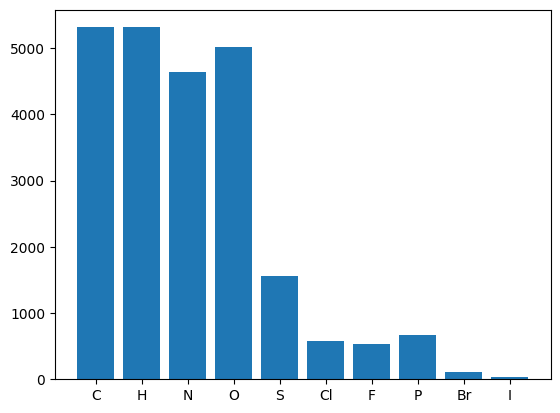

In [11]:
plt.bar(x,count)
plt.show()

Same thing as above except with bond types in the ligand file - Note: Include the "Not Connected" type as well, will come up in the future

In [12]:
count = 0
Bond_type_count = {}
for filename in os.listdir(CFG.pdbfiles):
    mol2_file = CFG.pdbfiles+filename+'/'+filename+'_ligand.mol2'
    bonds = get_bond_types_from_mol2(mol2_file)
    for bond in bonds:
        if bond in Bond_type_count:
            Bond_type_count[bond] += 1
        else:
            Bond_type_count.update({bond: 1})

Bond_type_count.update({'nc': 0})

In [13]:
x = []
bond_count = []
for bond in Bond_type_count:
    x.append(bond)
    bond_count.append(Bond_type_count[bond])

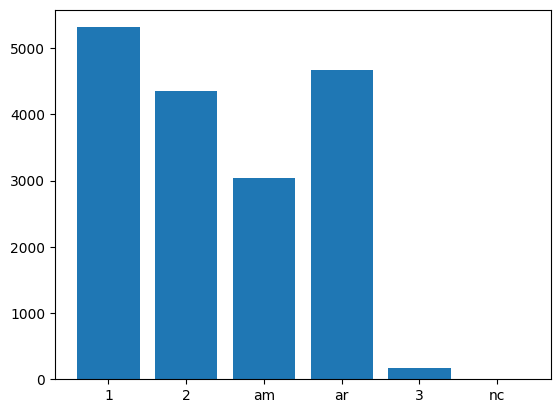

In [14]:
plt.bar(x,bond_count)
plt.show()

In [15]:
atom_type_dict = dict2embeding(Atom_type_count)
bond_type_dict = dict2embeding(Bond_type_count)
AA_dict = dict2embeding(AA_dictionary)

In [16]:
with open('atom_type_dict.pkl', 'wb') as f:
    pickle.dump(atom_type_dict, f)

In [17]:
with open('bond_type_dict.pkl', 'wb') as f:
    pickle.dump(bond_type_dict, f)

In [18]:
with open('AA_dict.pkl', 'wb') as f:
    pickle.dump(AA_dict, f)